In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    PowerTransformer, OneHotEncoder, OrdinalEncoder
)
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Конфигурация
RANDOM_STATE = 42
PLOT_STYLE = 'seaborn-v0_8'
plt.style.use(PLOT_STYLE)
sns.set_palette("husl")


class DataPreprocessor:
    def __init__(self, data: pd.DataFrame, target_col: str = None):
        self.target_col = target_col

        if target_col and target_col in data.columns:
            self.target = data[target_col][:10000].copy()
            self.data = data[:10000].drop(columns=[target_col]).copy()
        else:
            self.target = None
            self.data = data[:10000].copy()

        self.feature_types = {}
        self.report = {}


    def basic_analysis(self) -> dict:
        analysis = {
            'shape': self.data.shape,
            'dtypes': self.data.dtypes.to_dict(),
            'missing_values': self.data.isnull().sum().to_dict(),
            'missing_percentage': (self.data.isnull().sum() / len(self.data) * 100).to_dict(),
            'unique_values': self.data.nunique().to_dict(),
            'constant_features': [],
            'duplicates': self.data.duplicated().sum()
        }

        # Поиск константных признаков
        for col in self.data.columns:
            if self.data[col].nunique() == 1:
                analysis['constant_features'].append(col)

        # Сохранение отчета
        self.report['basic_analysis'] = analysis

        # Вывод результатов
        print("")
        print("Базовый анализ датасета")
        print("")
        print(f"Размер датасета: {analysis['shape']}")
        print(f"\nТипы данных:")
        for col, dtype in analysis['dtypes'].items():
            print(f"  {col}: {dtype}")

        print(f"\nПропуски:")
        for col, count in analysis['missing_values'].items():
            if count > 0:
                perc = analysis['missing_percentage'][col]
                print(f"  {col}: {count} ({perc:.2f}%)")

        print(f"\nКонстантные признаки: {analysis['constant_features']}")
        print(f"Дубликаты строк: {analysis['duplicates']}")

        return analysis

    def visual_eda(self, figsize=(15, 10)):
        self._identify_feature_types()

        num_features = self.feature_types['numeric']
        cat_features = self.feature_types['categorical']

        # Преобразуем все bool признаки в int (включая вновь созданные)
        for col in num_features:
            if self.data[col].dtype == bool:
                self.data[col] = self.data[col].astype(int)
                print(f"Колонка '{col}' преобразована из bool в int для визуализации")

        if num_features:
            n_cols = 3
            n_rows = (len(num_features) + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
            axes = axes.flatten()

            for idx, col in enumerate(num_features):
                axes[idx].hist(
                    self.data[col].dropna(),
                    bins=30,
                    edgecolor='black',
                    alpha=0.7
                )
                axes[idx].set_title(f'Распределение {col}')
                axes[idx].set_xlabel(col)
                axes[idx].set_ylabel('Частота')

            for idx in range(len(num_features), len(axes)):
                axes[idx].axis('off')

            plt.suptitle('Распределение числовых признаков', fontsize=16)
            plt.tight_layout()
            plt.show()

        if cat_features:
            n_cols = 2
            n_rows = (len(cat_features) + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
            axes = axes.flatten()

            for idx, col in enumerate(cat_features):
                value_counts = self.data[col].value_counts().head(10)
                axes[idx].bar(value_counts.index.astype(str), value_counts.values)
                axes[idx].set_title(f'Топ-10 значений {col}')
                axes[idx].set_xlabel(col)
                axes[idx].set_ylabel('Количество')
                axes[idx].tick_params(axis='x', rotation=45)

            for idx in range(len(cat_features), len(axes)):
                axes[idx].axis('off')

            plt.suptitle('Распределение категориальных признаков', fontsize=16)
            plt.tight_layout()
            plt.show()

        binary_features = self.feature_types.get('binary', [])
        corr_features = num_features + binary_features

        corr_df = self.data[corr_features].copy()

        target_included = False
        if self.target is not None and pd.api.types.is_numeric_dtype(self.target):
            corr_df[self.target_col] = self.target.values
            target_included = True

        if corr_df.shape[1] > 1:
            plt.figure(figsize=(12, 10))

            corr_matrix = corr_df.corr()

            sns.heatmap(
                corr_matrix,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                linewidths=0.5
            )

            title = 'Корреляционная матрица'
            if target_included:
                title += ' + целевой признак'

            plt.title(title, fontsize=16)
            plt.tight_layout()
            plt.show()

        if num_features:
            plt.figure(figsize=(15, 6))
            data_melted = pd.melt(self.data[num_features])
            sns.boxplot(x='variable', y='value', data=data_melted)
            plt.title('Boxplot числовых признаков', fontsize=16)
            plt.xlabel('Признаки')
            plt.ylabel('Значения')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    def _identify_feature_types(self):
        numeric = []
        categorical = []
        binary = []
        datetime_cols = []

        for col in self.data.columns:
            if col == self.target_col:
                continue

            col_data = self.data[col]

            if pd.api.types.is_datetime64_any_dtype(col_data):
                datetime_cols.append(col)
                continue

            if pd.api.types.is_numeric_dtype(col_data):
                unique_vals = col_data.nunique(dropna=True)

                if unique_vals == 2 and col_data.dtype not in [np.uint8, bool]:
                    binary.append(col)
                else:
                    numeric.append(col)

            else:
                categorical.append(col)

        self.feature_types = {
            'numeric': numeric,
            'categorical': categorical,
            'binary': binary,
            'datetime': datetime_cols
        }

        print("")
        print("Определение типов признаков")
        print("")
        print(f"Числовые признаки ({len(numeric)}): {numeric}")
        print(f"Категориальные признаки ({len(categorical)}): {categorical}")
        print(f"Бинарные признаки ({len(binary)}): {binary}")
        print(f"Datetime признаки ({len(datetime_cols)}): {datetime_cols}")

        return self.feature_types


    def process_datetime_features(self, datetime_cols=None, cyclical_encoding=True):

        if datetime_cols is None:
            datetime_cols = self.feature_types.get('datetime', [])

        new_features = []

        for col in datetime_cols:
            if col not in self.data.columns:
                continue

            # Базовые признаки
            self.data[f'{col}_year'] = self.data[col].dt.year
            self.data[f'{col}_month'] = self.data[col].dt.month
            self.data[f'{col}_day'] = self.data[col].dt.day
            self.data[f'{col}_weekday'] = self.data[col].dt.weekday
            self.data[f'{col}_hour'] = self.data[col].dt.hour if hasattr(self.data[col].dt, 'hour') else 0
            self.data[f'{col}_is_weekend'] = self.data[col].dt.weekday >= 5

            new_features.extend([
                f'{col}_year', f'{col}_month', f'{col}_day',
                f'{col}_weekday', f'{col}_hour', f'{col}_is_weekend'
            ])

            # Cyclical encoding для месяца и часа
            if cyclical_encoding:
                # Месяц
                self.data[f'{col}_month_sin'] = np.sin(2 * np.pi * self.data[f'{col}_month'] / 12)
                self.data[f'{col}_month_cos'] = np.cos(2 * np.pi * self.data[f'{col}_month'] / 12)

                # Час (если есть)
                if f'{col}_hour' in self.data.columns:
                    self.data[f'{col}_hour_sin'] = np.sin(2 * np.pi * self.data[f'{col}_hour'] / 24)
                    self.data[f'{col}_hour_cos'] = np.cos(2 * np.pi * self.data[f'{col}_hour'] / 24)

                new_features.extend([
                    f'{col}_month_sin', f'{col}_month_cos',
                    f'{col}_hour_sin', f'{col}_hour_cos'
                ])

        # Удаление исходных datetime колонок
        self.data = self.data.drop(columns=datetime_cols)

        # Обновление типов признаков
        self._identify_feature_types()

        print(f"Создано {len(new_features)} новых признаков из datetime")
        return self.data

    def encode_categorical(
        self,
        method='onehot',
        max_cardinality=30,
        target=None,
        **kwargs
    ):
        cat_features = self.feature_types.get('categorical', [])

        safe_features = [
            col for col in cat_features
            if self.data[col].nunique() <= max_cardinality
        ]

        skipped = list(set(cat_features) - set(safe_features))

        if skipped:
            print(f"Пропущены high-cardinality признаки: {skipped}")

        if not safe_features:
            print("Нет категориальных признаков для кодирования")
            return self.data

        if method == 'onehot':
            encoder = OneHotEncoder(
                sparse_output=False,
                handle_unknown='ignore',
                **kwargs
            )
            encoded = encoder.fit_transform(self.data[safe_features])
            encoded_df = pd.DataFrame(
                encoded,
                columns=encoder.get_feature_names_out(safe_features),
                index=self.data.index
            )

        # удаляем и добавляем
        self.data.drop(columns=safe_features, inplace=True)
        self.data = pd.concat([self.data, encoded_df], axis=1)

        self._identify_feature_types()
        print(f"Категориальные признаки закодированы методом: {method}")

        return self.data

    def scale_features(self, method='standard', numeric_cols=None):
        if numeric_cols is None:
            numeric_cols = self.feature_types.get('numeric', [])

        if not numeric_cols:
            print("Нет числовых признаков для масштабирования")
            return self.data

        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler()
        elif method == 'robust':
            scaler = RobustScaler()
        elif method == 'power':
            scaler = PowerTransformer(method='yeo-johnson')
        else:
            raise ValueError(f"Неизвестный метод масштабирования: {method}")

        # Масштабируем признаки
        scaled_data = scaler.fit_transform(self.data[numeric_cols])
        self.data[numeric_cols] = scaled_data

        print(f"Числовые признаки масштабированы методом: {method}")
        return self.data, scaler

    def detect_outliers(self, method='iqr', **kwargs):
        numeric_cols = self.feature_types.get('numeric', [])

        if not numeric_cols:
            print("Нет числовых признаков для анализа выбросов")
            return pd.Series([False] * len(self.data))

        X = self.data[numeric_cols].copy()

        # Масштабирование для чувствительных методов
        if method in ['isolation_forest', 'one_class_svm', 'dbscan', 'lof']:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        numeric_cols = self.feature_types.get('numeric', [])

        if not numeric_cols:
            print("Нет числовых признаков для анализа выбросов")
            return pd.Series([False] * len(self.data))

        if method == 'iqr':
            # Метод межквартильного размаха
            outliers_mask = pd.Series([False] * len(self.data))
            for col in numeric_cols:
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                col_outliers = (self.data[col] < lower_bound) | (self.data[col] > upper_bound)
                outliers_mask = outliers_mask | col_outliers

        elif method == 'isolation_forest':
            model = IsolationForest(
                contamination=kwargs.get('contamination', 0.1),
                random_state=RANDOM_STATE,
                **kwargs
            )
            outliers_mask = model.fit_predict(X) == -1

        elif method == 'one_class_svm':
            model = OneClassSVM(
                nu=kwargs.get('nu', 0.1),
                kernel=kwargs.get('kernel', 'rbf'),
                **kwargs
            )
            outliers_mask = model.fit_predict(X) == -1

        elif method == 'dbscan':
            model = DBSCAN(
                eps=kwargs.get('eps', 0.5),
                min_samples=kwargs.get('min_samples', 5),
                **kwargs
            )
            outliers_mask = model.fit_predict(X) == -1

        elif method == 'lof':
            model = LocalOutlierFactor(
                contamination=kwargs.get('contamination', 0.1),
                **kwargs
            )
            outliers_mask = model.fit_predict(X) == -1

        elif method == 'zscore':
            # Robust Z-score (использует медиану и MAD)
            outliers_mask = pd.Series([False] * len(self.data))
            for col in numeric_cols:
                median = np.median(self.data[col])
                mad = np.median(np.abs(self.data[col] - median))
                if mad == 0:
                    continue
                if mad > 0:
                    z_scores = 0.6745 * (self.data[col] - median) / mad
                    col_outliers = np.abs(z_scores) > kwargs.get('threshold', 3.5)
                    outliers_mask = outliers_mask | col_outliers

        else:
            raise ValueError(f"Неизвестный метод обнаружения выбросов: {method}")

        # Визуализация
        n_outliers = outliers_mask.sum()
        print(f"Найдено выбросов: {n_outliers} ({n_outliers/len(self.data)*100:.2f}%)")

        if n_outliers > 0:
            # Boxplot до и после удаления выбросов
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            # До удаления
            data_before = pd.melt(self.data[numeric_cols[:min(5, len(numeric_cols))]])
            sns.boxplot(x='variable', y='value', data=data_before, ax=axes[0])
            axes[0].set_title('До обработки выбросов')
            axes[0].tick_params(axis='x', rotation=45)

            # После удаления
            clean_data = self.data[~outliers_mask]
            data_after = pd.melt(clean_data[numeric_cols[:min(5, len(numeric_cols))]])
            sns.boxplot(x='variable', y='value', data=data_after, ax=axes[1])
            axes[1].set_title('После обработки выбросов')
            axes[1].tick_params(axis='x', rotation=45)

            plt.tight_layout()
            plt.show()

        return outliers_mask

    def impute_missing(self, method='auto', numeric_cols=None, **kwargs):
        if numeric_cols is None:
            numeric_cols = self.feature_types.get('numeric', [])

        # Категориальные - mode
        cat_features = self.feature_types.get('categorical', [])
        for col in cat_features:
            if self.data[col].isnull().any():
                mode_val = self.data[col].mode()[0] if not self.data[col].mode().empty else 'Unknown'
                self.data[col].fillna(mode_val, inplace=True)

        binary_features = self.feature_types.get('binary', [])
        for col in binary_features:
            if self.data[col].isnull().any():
                mode_val = self.data[col].mode()[0] if not self.data[col].mode().empty else 0
                self.data[col].fillna(mode_val, inplace=True)

        if not numeric_cols:
            return self.data

        if method == 'auto':
            best_method = None
            best_score = -np.inf

            for impute_method in ['mean', 'median', 'knn', 'mice']:
                try:
                    temp_data = self.data.copy()
                    temp_data = self._apply_imputation(
                        temp_data, impute_method, numeric_cols, **kwargs
                    )

                    pvalues = []

                    for col in numeric_cols:
                        # исключаем бинарные
                        if col in self.feature_types.get('binary', []):
                            continue

                        mask_missing = self.data[col].isnull()
                        if mask_missing.sum() < 5:
                            continue

                        orig_data = self.data.loc[~mask_missing, col]
                        imputed_data = temp_data.loc[mask_missing, col]

                        if len(orig_data) > 20 and len(imputed_data) > 5:
                            _, pvalue = stats.ks_2samp(orig_data, imputed_data)
                            pvalues.append(pvalue)

                    avg_pvalue = np.mean(pvalues) if pvalues else -np.inf

                    if avg_pvalue > best_score:
                        best_score = avg_pvalue
                        best_method = impute_method

                except Exception as e:
                    print(f"Ошибка в методе {impute_method}: {e}")
                    continue

            print(
                f"Выбран метод: {best_method} "
                f"(средний p-value KS-теста: {best_score:.4f})"
            )
            method = best_method

        # Применяем выбранный метод
        self.data = self._apply_imputation(self.data, method, numeric_cols, **kwargs)

        print(f"Пропуски заполнены методом: {method}")
        return self.data


    def _apply_imputation(self, data, method, numeric_cols, **kwargs):
        data = data.copy()

        for col in numeric_cols:
            if data[col].isnull().any():
                if method == 'mean':
                    data[col].fillna(data[col].mean(), inplace=True)
                elif method == 'median':
                    data[col].fillna(data[col].median(), inplace=True)
                elif method == 'mode':
                    mode_val = data[col].mode()[0] if not data[col].mode().empty else 0
                    data[col].fillna(mode_val, inplace=True)
                elif method == 'constant':
                    const_val = kwargs.get('value', 0)
                    data[col].fillna(const_val, inplace=True)

        if method == 'knn':
            imputer = KNNImputer(n_neighbors=kwargs.get('n_neighbors', 5))
            data[numeric_cols] = imputer.fit_transform(data[numeric_cols])
        elif method == 'mice':
            imputer = IterativeImputer(
                max_iter=kwargs.get('max_iter', 10),
                random_state=RANDOM_STATE
            )
            data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

        return data

    def select_features(self, method='variance', target=None, **kwargs):
        if method == 'variance':
            selector = VarianceThreshold(threshold=kwargs.get('threshold', 0))
            selector.fit(self.data.select_dtypes(include=[np.number]))
            selected_features = self.data.select_dtypes(include=[np.number]).columns[
                selector.get_support()
            ].tolist()

        elif method == 'correlation':
            # Удаляем высокоскоррелированные признаки
            numeric_data = self.data.select_dtypes(include=[np.number])
            correlation_matrix = numeric_data.corr().abs()
            upper_triangle = correlation_matrix.where(
                np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
            )

            threshold = kwargs.get('threshold', 0.85)
            to_drop = [
                column for column in upper_triangle.columns
                if any(upper_triangle[column] > threshold)
            ]

            selected_features = [
                col for col in self.data.columns
                if col not in to_drop
            ]

        elif method == 'kbest' and target is not None:
            k = kwargs.get('k', 'all')
            score_func = kwargs.get('score_func', f_regression)

            selector = SelectKBest(score_func=score_func, k=k)
            X = self.data.copy()
            selector.fit(X, target)
            selected_features = X.columns[selector.get_support()].tolist()

            selected_features = self.data.drop(
                columns=[self.target_col] if self.target_col in self.data.columns else []
            ).columns[selector.get_support()].tolist()

        elif method == 'importance' and target is not None:
            # Используем важность признаков на основе случайного леса
            from sklearn.ensemble import RandomForestRegressor

            model = RandomForestRegressor(
                n_estimators=kwargs.get('n_estimators', 100),
                random_state=RANDOM_STATE,
                n_jobs=-1
            )

            X = self.data.copy()
            model.fit(X, target)

            importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            # Выбираем признаки с важностью выше порога
            threshold = kwargs.get('threshold', 0.01)
            selected_features = importance_df[
                importance_df['importance'] > threshold
            ]['feature'].tolist()

            # Визуализация важности признаков
            plt.figure(figsize=(12, 8))
            top_n = min(20, len(importance_df))
            sns.barplot(x='importance', y='feature',
                       data=importance_df.head(top_n))
            plt.title(f'Top-{top_n} важнейших признаков', fontsize=16)
            plt.tight_layout()
            plt.show()

        else:
            selected_features = self.data.columns.tolist()
            if self.target_col in selected_features:
                selected_features.remove(self.target_col)

        print(f"Отобрано признаков методом {method}: {len(selected_features)} из {len(self.data.columns)}")
        print(f"Отобранные признаки: {selected_features}")

        return selected_features

    def sanitize_columns(
        self,
        id_threshold=0.9,
        datetime_parse_ratio=0.8
    ):

        cols_to_drop = []
        datetime_cols = []

        n_rows = len(self.data)

        for col in self.data.columns:
            col_data = self.data[col]

            # 1. ID / UUID / hash
            if col_data.dtype == 'object':
                unique_ratio = col_data.nunique(dropna=True) / n_rows

                if unique_ratio > id_threshold:
                    cols_to_drop.append(col)
                    continue

            # 2. Попытка привести к datetime
            if col_data.dtype == 'object':
                parsed = pd.to_datetime(col_data, errors='coerce')
                success_ratio = parsed.notna().mean()

                if success_ratio >= datetime_parse_ratio:
                    self.data[col] = parsed
                    datetime_cols.append(col)

        if cols_to_drop:
            print(f"Удалены ID-подобные колонки: {cols_to_drop}")
            self.data.drop(columns=cols_to_drop, inplace=True)

        if datetime_cols:
            print(f"Распознаны datetime колонки: {datetime_cols}")

        return self.data
    
    def apply_selected_features(self, selected_features):
      self.data = self.data[selected_features]

    def convert_columns_to_datetime(
        self,
        columns,
        errors='coerce',
        infer_datetime_format=True
    ):

        if isinstance(columns, str):
            columns = [columns]

        results = {}

        for col in columns:
            if col not in self.data.columns:
                print(f"Колонка '{col}' не найдена")
                continue

            # 1. Обработка bool-типов
            if self.data[col].dtype == bool:
                self.data[col] = self.data[col].astype(int)
                print(f"Колонка '{col}' (bool) преобразована в бинарную (0/1)")
                results[col] = 1.0
                continue

            # 2. Обработка bool внутри object
            if self.data[col].dtype == object:
                if self.data[col].dropna().apply(lambda x: isinstance(x, bool)).any():
                    self.data[col] = self.data[col].map(
                        lambda x: int(x) if isinstance(x, bool) else x
                    )
                    print(
                        f"Колонка '{col}' содержит bool-значения → "
                        f"преобразованы в 0/1"
                    )

            # 3. Приведение к datetime
            parsed = pd.to_datetime(
                self.data[col],
                errors=errors,
                infer_datetime_format=infer_datetime_format
            )

            success_ratio = parsed.notna().mean()
            self.data[col] = parsed
            results[col] = success_ratio

            print(
                f"Колонка '{col}' приведена к datetime "
                f"(успешно: {success_ratio:.2%})"
            )

        return results

    def get_ml_data(self):
        """
        Возвращает данные для обучения моделей
        """
        return self.data.copy(), self.target.copy()


def load_and_preprocess_data(filepath, target_col=None):
    # Загрузка данных
    if filepath.endswith('.csv'):
        data = pd.read_csv(filepath)
    elif filepath.endswith('.xlsx'):
        data = pd.read_excel(filepath)
    elif filepath.endswith('.parquet'):
        data = pd.read_parquet(filepath)
    else:
        raise ValueError("Неподдерживаемый формат файла")

    # Создание предобработчика
    preprocessor = DataPreprocessor(data, target_col)

    return preprocessor



def run_full_pipeline(filepath, target_col=None, save_report_path=None):
    print("")
    print("Предобработка датасета")
    print("")

    # 1. Загрузка данных
    preprocessor = load_and_preprocess_data(filepath, target_col)

    # 2. Базовый анализ
    preprocessor.basic_analysis()

    # Только для этого датасета
    preprocessor.convert_columns_to_datetime([
    'pickup_datetime',
    'dropoff_datetime'
    ])

    # 3. Определение типов признаков
    preprocessor.sanitize_columns()
    preprocessor._identify_feature_types()

    if preprocessor.feature_types.get('datetime'):
        preprocessor.process_datetime_features()

    preprocessor.encode_categorical(method='onehot')

    # 4. Визуальное EDA
    preprocessor.visual_eda()

    # 5. Обработка datetime (если есть)
    if preprocessor.feature_types.get('datetime'):
        preprocessor.process_datetime_features()

    # 6. Заполнение пропусков
    preprocessor.impute_missing(method='auto')

    # 8. Масштабирование
    preprocessor.scale_features(method='standard')

    # 9. Детекция выбросов
    outliers_mask = preprocessor.detect_outliers(method='iqr')

    # 10. Отбор признаков
    if preprocessor.target is not None:
        target = preprocessor.target
        selected_features = preprocessor.select_features(
            method='importance',
            target=target
        )
    else:
        selected_features = preprocessor.select_features(method='correlation')
      
    preprocessor.apply_selected_features(selected_features)

    preprocessor.visual_eda()

    print("\n")
    print()

    return preprocessor


Предобработка датасета


Базовый анализ датасета

Размер датасета: (10000, 11)

Типы данных:
  carat: float64
  cut: int64
  color: int64
  clarity: int64
  depth: float64
  table: int64
  x: float64
  y: float64
  z: float64
  volume: float64
  density: float64

Пропуски:

Константные признаки: []
Дубликаты строк: 30
Колонка 'pickup_datetime' не найдена
Колонка 'dropoff_datetime' не найдена

Определение типов признаков

Числовые признаки (11): ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'volume', 'density']
Категориальные признаки (0): []
Бинарные признаки (0): []
Datetime признаки (0): []
Нет категориальных признаков для кодирования

Определение типов признаков

Числовые признаки (11): ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'volume', 'density']
Категориальные признаки (0): []
Бинарные признаки (0): []
Datetime признаки (0): []


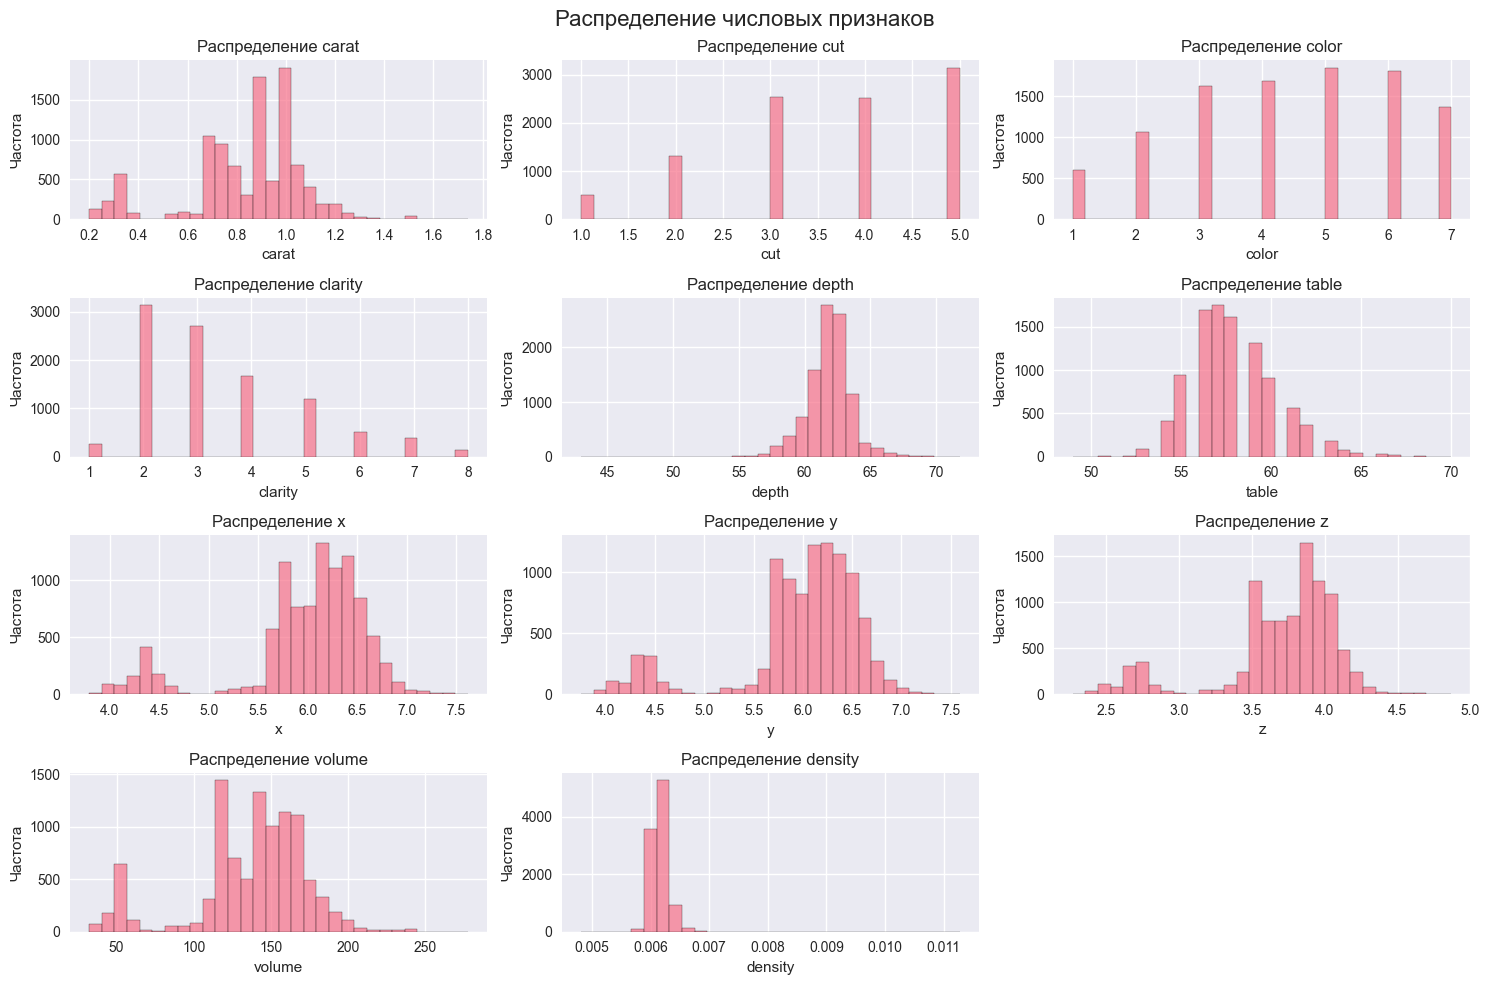

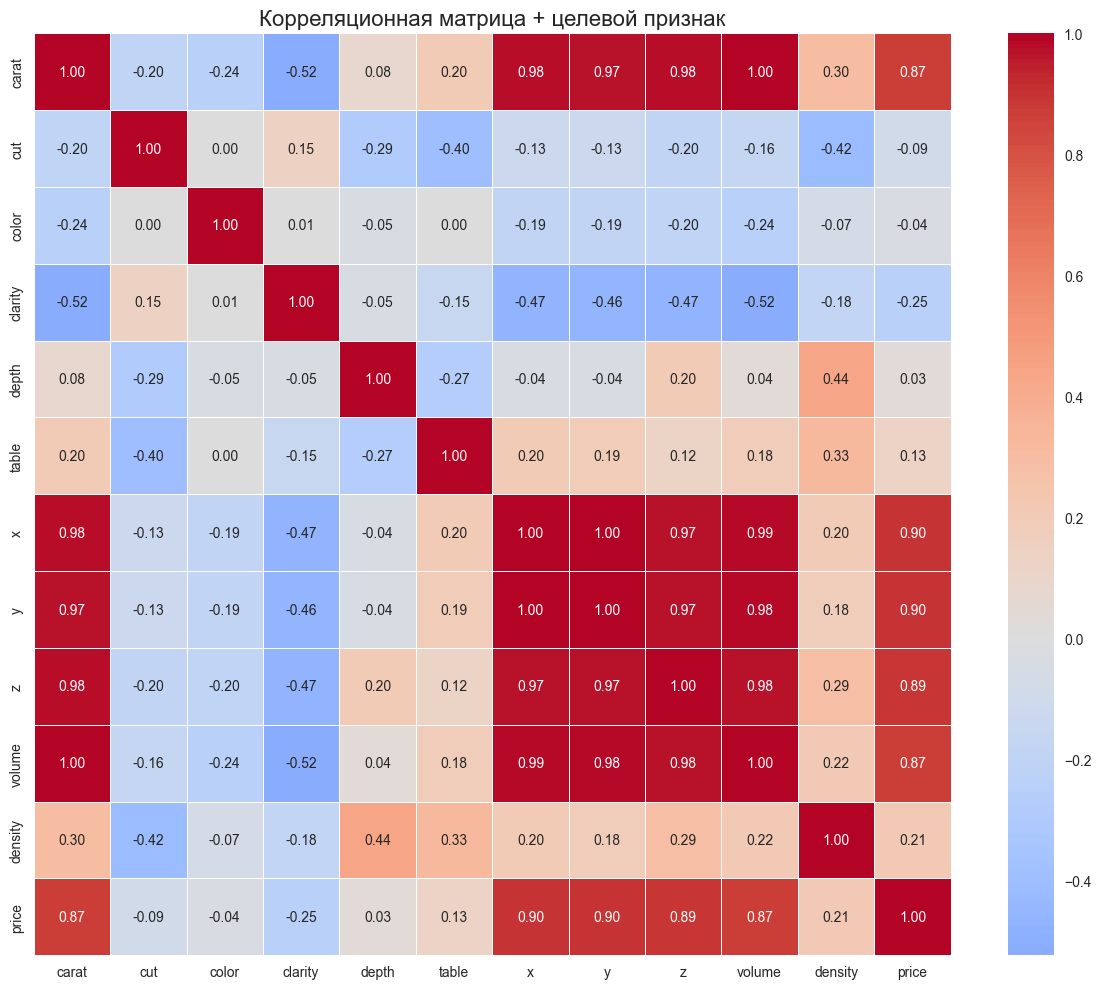

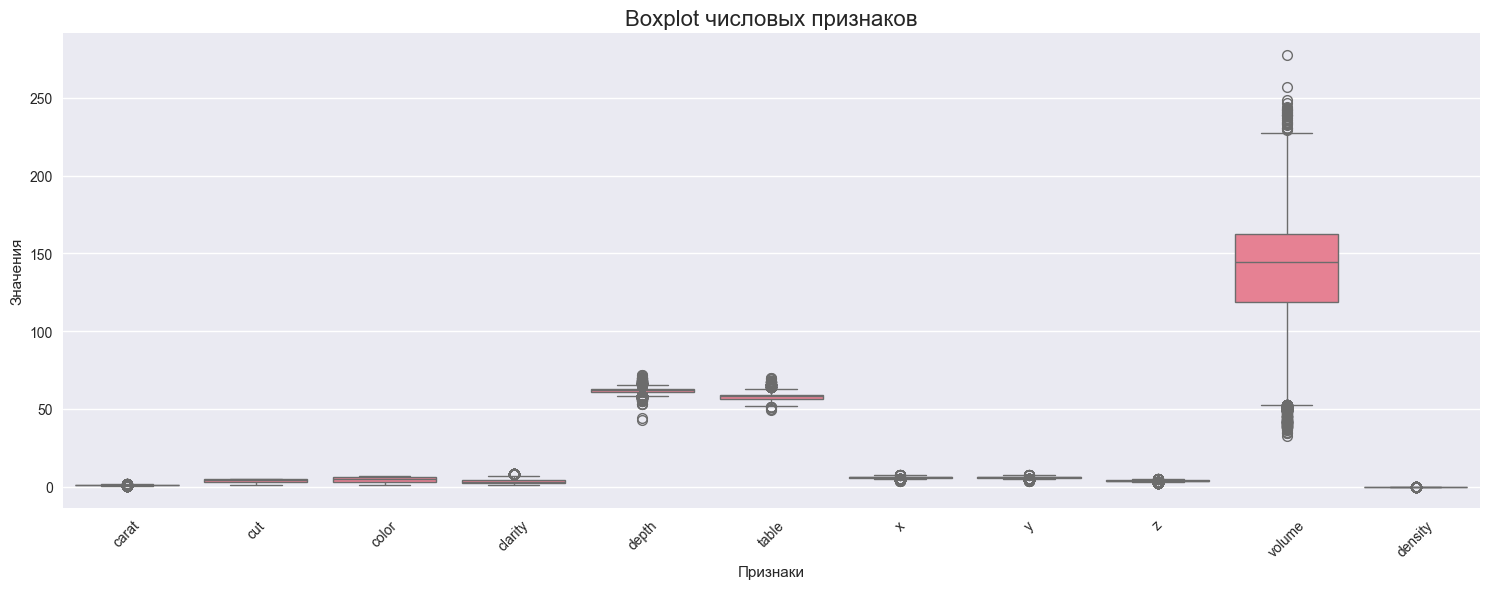

Выбран метод: None (средний p-value KS-теста: -inf)
Пропуски заполнены методом: None
Числовые признаки масштабированы методом: standard
Найдено выбросов: 1898 (18.98%)


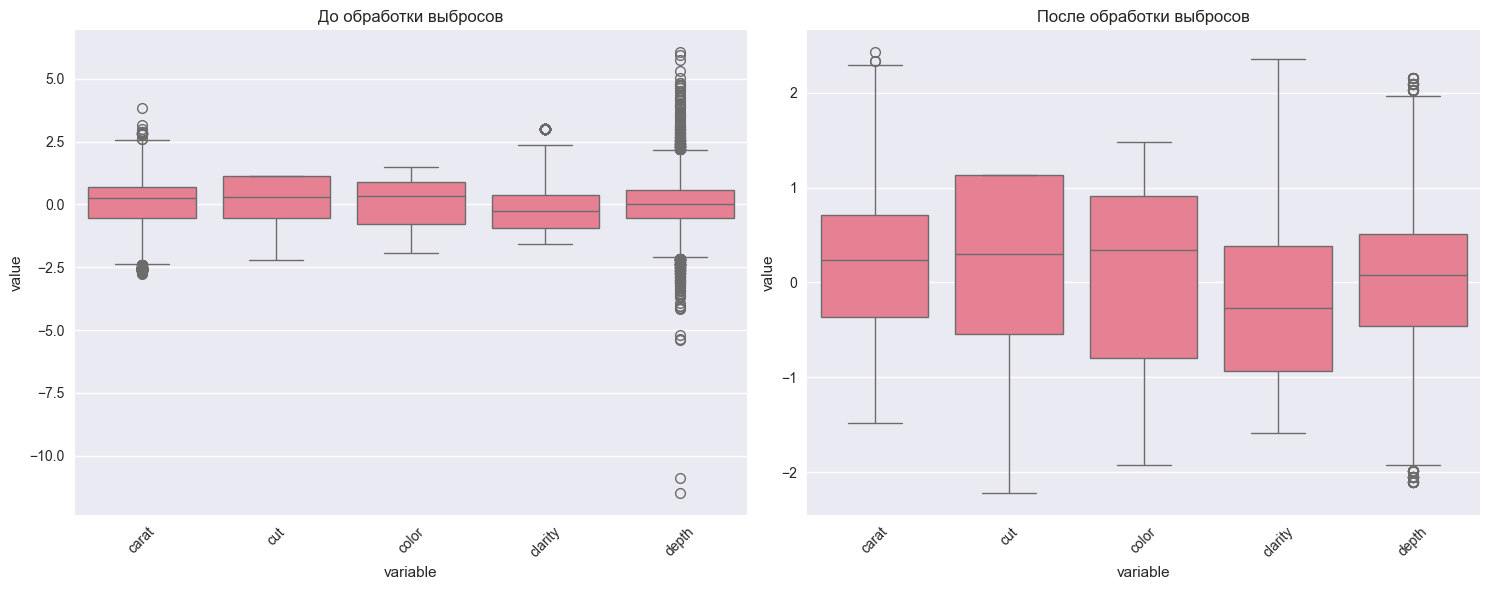

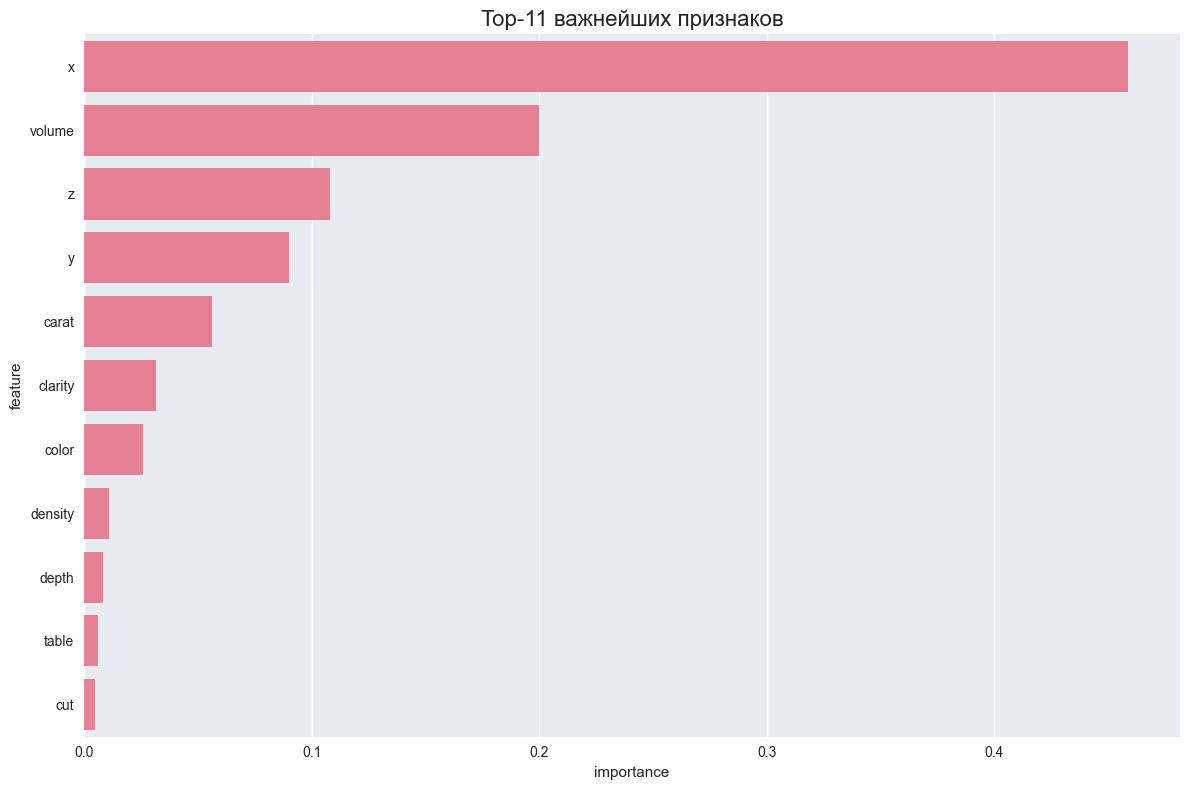

Отобрано признаков методом importance: 8 из 11
Отобранные признаки: ['x', 'volume', 'z', 'y', 'carat', 'clarity', 'color', 'density']

Определение типов признаков

Числовые признаки (8): ['x', 'volume', 'z', 'y', 'carat', 'clarity', 'color', 'density']
Категориальные признаки (0): []
Бинарные признаки (0): []
Datetime признаки (0): []


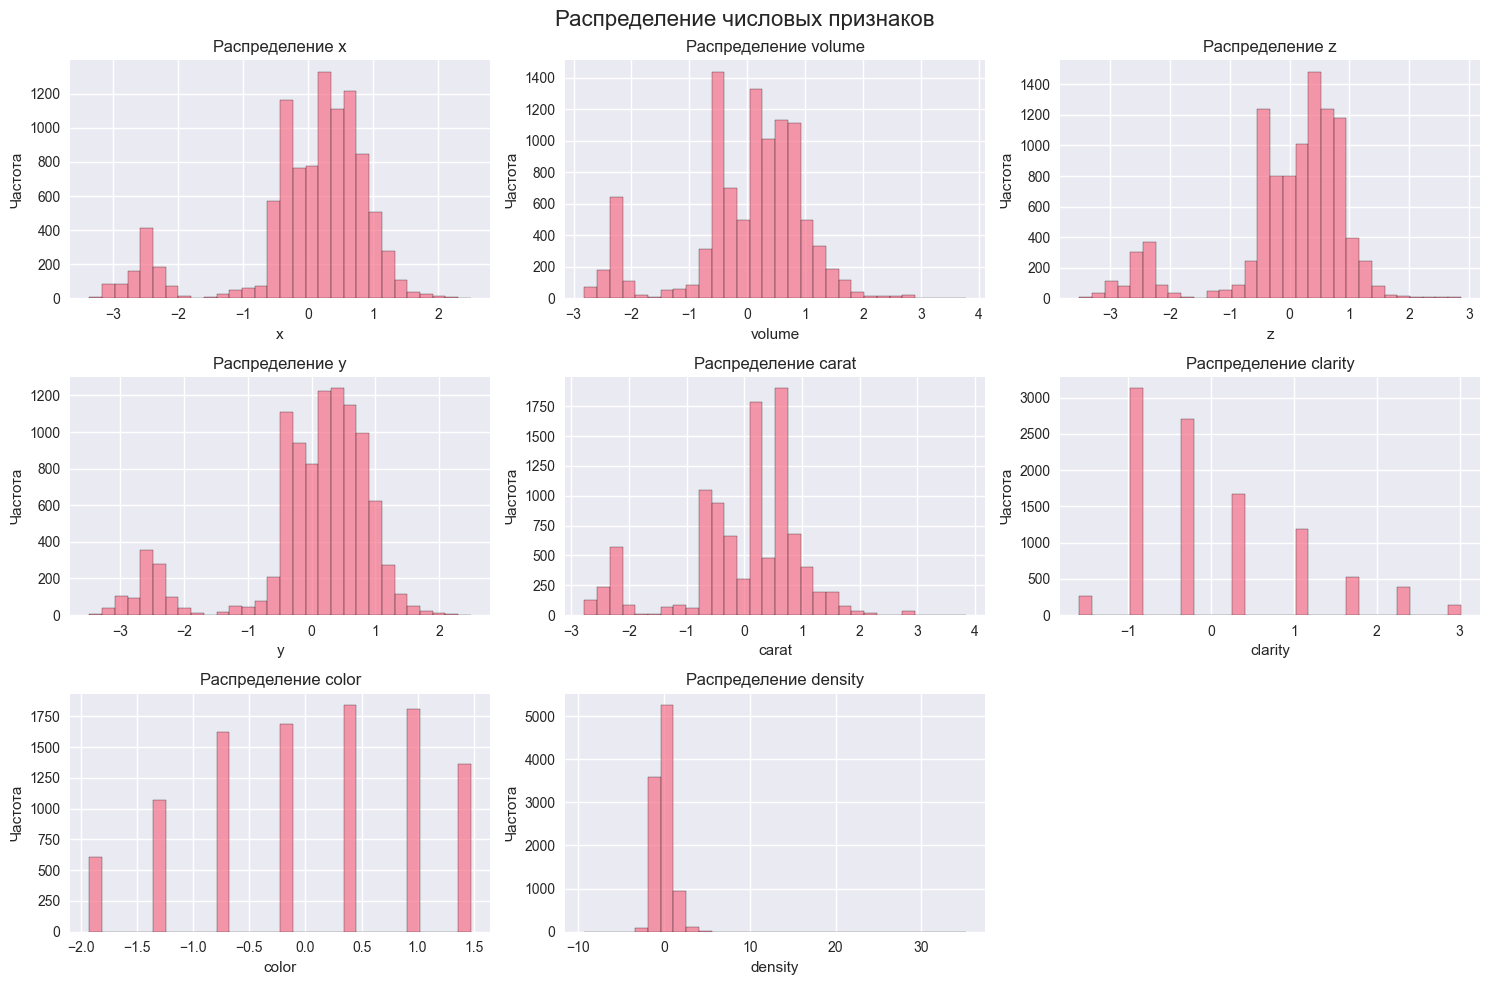

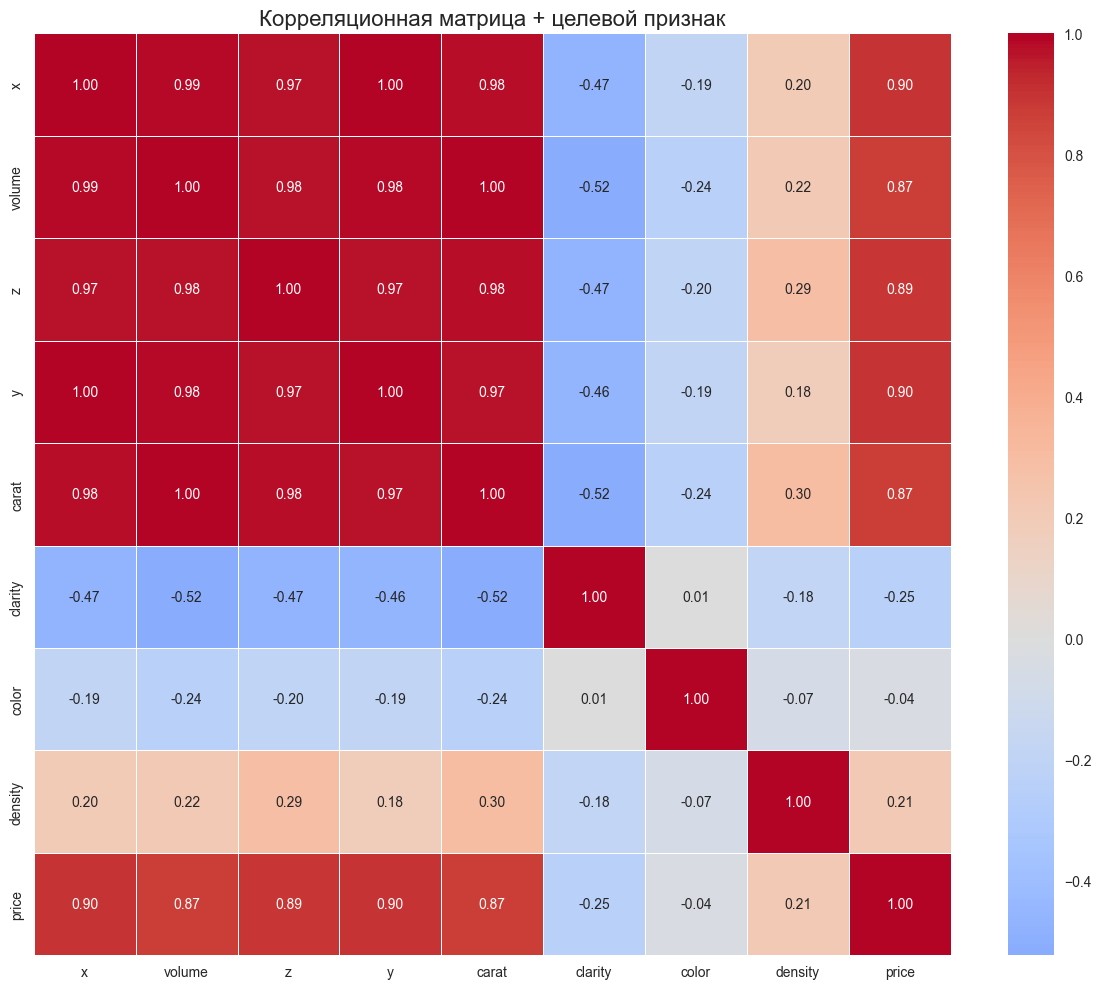

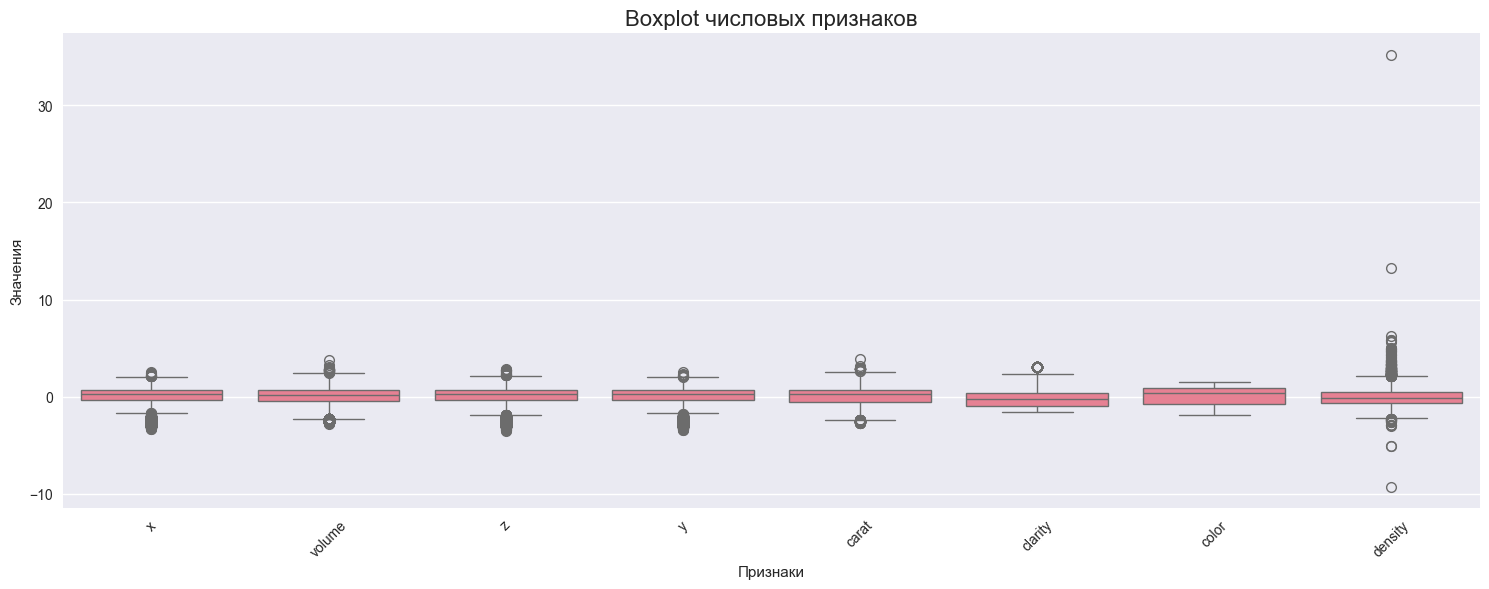

In [16]:
preprocessor = run_full_pipeline(filepath = "data_regression.csv", target_col = "price")

In [31]:
!pip install catboost
import time
import joblib
import numpy as np
import pandas as pd

from typing import Dict, Any, Tuple

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC

from imblearn.over_sampling import SMOTE

import xgboost as xgb
import catboost as cb

class ClassificationNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)


class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.network(x)


def extract_data_from_preprocessor(preprocessor):
    X, y = preprocessor.get_ml_data()

    column_transformer = None
    if hasattr(preprocessor, "get_column_transformer"):
        column_transformer = preprocessor.get_column_transformer()

    return X, y, column_transformer

def train_torch_model(
    model,
    train_loader,
    valid_loader,
    task_type,
    epochs=30,
    lr=1e-3,
    device="cpu"
):
    model.to(device)

    if task_type == "classification":
        criterion = nn.NLLLoss()
    else:
        criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)

            if task_type == "regression":
                preds = preds.squeeze()

            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    return model

def evaluate_torch_model(
    model,
    loader,
    task_type,
    device="cpu"
):
    model.eval()
    y_true, y_pred, y_proba = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            outputs = model(xb)

            if task_type == "classification":
                probs = torch.exp(outputs)
                preds = torch.argmax(probs, dim=1)
                y_proba.extend(probs[:, 1].cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
            else:
                y_pred.extend(outputs.squeeze().cpu().numpy())

            y_true.extend(yb.numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_proba) if y_proba else None

def train_neural_networks(
    X_train,
    X_valid,
    y_train,
    y_valid,
    task_type,
    epochs=20,
    batch_size=64,
    device="cpu",
    save_metrics_path=None
):

    print("\nОбучение нейросетей")

    # numpy -> torch
    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    X_valid_t = torch.tensor(X_valid.values, dtype=torch.float32)

    if task_type == "classification":
        y_train_t = torch.tensor(y_train.values, dtype=torch.long)
        y_valid_t = torch.tensor(y_valid.values, dtype=torch.long)
        num_classes = len(np.unique(y_train))
        model = ClassificationNN(X_train.shape[1], num_classes)
    else:
        y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
        y_valid_t = torch.tensor(y_valid.values, dtype=torch.float32)
        model = RegressionNN(X_train.shape[1])

    train_ds = TensorDataset(X_train_t, y_train_t)
    valid_ds = TensorDataset(X_valid_t, y_valid_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

    start = time.time()
    model = train_torch_model(
        model,
        train_loader,
        valid_loader,
        task_type,
        epochs=epochs,
        device=device
    )
    train_time = time.time() - start

    y_tr, y_tr_pred, y_tr_proba = evaluate_torch_model(
        model, train_loader, task_type, device
    )
    y_val, y_val_pred, y_val_proba = evaluate_torch_model(
        model, valid_loader, task_type, device
    )

    train_metrics = calculate_metrics(
        y_tr, y_tr_pred, y_tr_proba, task_type
    )
    valid_metrics = calculate_metrics(
        y_val, y_val_pred, y_val_proba, task_type
    )

    # Сохраняем метрики, если путь указан
    result = {
        "model_name": "NeuralNetwork",
        "model": model,
        "train_metrics": train_metrics,
        "valid_metrics": valid_metrics,
        "train_time": train_time,
        "pipeline": None  # Для совместимости с другими моделями
    }

    # Сохраняем метрики в CSV в том же формате
    if save_metrics_path:
        metrics_row = {
            "model": "NeuralNetwork",
            "train_time_sec": train_time
        }
        
        # Добавляем train метрики
        for metric_name, metric_value in train_metrics.items():
            metrics_row[f"train_{metric_name}"] = metric_value
        
        # Добавляем valid метрики
        for metric_name, metric_value in valid_metrics.items():
            metrics_row[f"valid_{metric_name}"] = metric_value
        
        # Сохраняем в файл
        df_metrics = pd.DataFrame([metrics_row])
        
        # Проверяем, существует ли файл, и записываем с заголовком или без
        if os.path.exists(save_metrics_path):
            df_existing = pd.read_csv(save_metrics_path)
            df_combined = pd.concat([df_existing, df_metrics], ignore_index=True)
            df_combined.to_csv(save_metrics_path, index=False)
        else:
            df_metrics.to_csv(save_metrics_path, index=False)
        
        print(f"Метрики нейросети сохранены в: {save_metrics_path}")

    return result


def make_train_valid_split(
    X: pd.DataFrame,
    y: pd.Series,
    task_type: str,
    test_size: float = 0.2,
    random_state: int = 42,
    time_column: str = None
) -> Tuple:
    if time_column:
        X = X.sort_values(time_column)
        y = y.loc[X.index]
        split_idx = int(len(X) * (1 - test_size))
        return (
            X.iloc[:split_idx],
            X.iloc[split_idx:],
            y.iloc[:split_idx],
            y.iloc[split_idx:]
        )

    stratify = y if task_type == "classification" else None

    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify
    )

from sklearn.pipeline import Pipeline

def build_pipeline(preprocessor, model):
    if preprocessor is None:
        return Pipeline([
            ("model", model)
        ])

    return Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

def get_models(task_type: str) -> Dict[str, Any]:
    if task_type == "regression":
        models = {
            "Ridge": Ridge(),
            "Lasso": Lasso(),
            "ElasticNet": ElasticNet(),
            "RandomForest": RandomForestRegressor(random_state=42),
            "KNN": KNeighborsRegressor(),
            "SVR": SVR()
        }
        models["XGBoost"] = xgb.XGBRegressor(random_state=42)
        models["CatBoost"] = cb.CatBoostRegressor(verbose=0)

    else:
        models = {
            "LogisticRegression": LogisticRegression(max_iter=1000),
            "RandomForest": RandomForestClassifier(random_state=42),
            "KNN": KNeighborsClassifier(),
            "SVC": SVC(probability=True)
        }

        models["XGBoost"] = xgb.XGBClassifier(random_state=42)
        models["CatBoost"] = cb.CatBoostClassifier(verbose=0)

    return models

def calculate_metrics(
    y_true,
    y_pred,
    y_proba=None,
    task_type: str = "regression"
):

    if task_type == "regression":
        return {
            "MAE": mean_absolute_error(y_true, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "R2": r2_score(y_true, y_pred)
        }

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    }

    if y_proba is not None:
        metrics["ROC_AUC"] = roc_auc_score(y_true, y_proba)

    return metrics

def train_single_model(
    model_name,
    model,
    X_train,
    X_valid,
    y_train,
    y_valid,
    preprocessor,
    task_type
):
    print(f"Обучение: {model_name}")

    pipeline = build_pipeline(preprocessor, model)

    start = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start

    y_train_pred = pipeline.predict(X_train)
    y_train_proba = None
    if task_type == "classification" and hasattr(pipeline, "predict_proba"):
        y_train_proba = pipeline.predict_proba(X_train)[:, 1]

    train_metrics = calculate_metrics(
        y_train, y_train_pred, y_train_proba, task_type
    )

    y_valid_pred = pipeline.predict(X_valid)
    y_valid_proba = None
    if task_type == "classification" and hasattr(pipeline, "predict_proba"):
        y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]

    valid_metrics = calculate_metrics(
        y_valid, y_valid_pred, y_valid_proba, task_type
    )

    return {
        "model_name": model_name,
        "pipeline": pipeline,
        "train_metrics": train_metrics,
        "valid_metrics": valid_metrics,
        "train_time": train_time
    }

import os

def train_all_models(
    X_train,
    X_valid,
    y_train,
    y_valid,
    preprocessor,
    task_type: str,
    save_metrics_path: str = "Test/metrics.csv"  # по умолчанию сохраняем в Test/metrics.csv
) -> pd.DataFrame:

    results = []
    models = get_models(task_type)

    for name, model in models.items():
        try:
            result = train_single_model(
                name,
                model,
                X_train,
                X_valid,
                y_train,
                y_valid,
                preprocessor,
                task_type
            )
            results.append(result)
        except Exception as e:
            print(f"Ошибка в модели {name}: {e}")

    report = pd.DataFrame([{
        "model": r["model_name"],
        **{f"train_{k}": v for k, v in r["train_metrics"].items()},
        **{f"valid_{k}": v for k, v in r["valid_metrics"].items()},
        "train_time_sec": r["train_time"]
    } for r in results])

    # Сохраняем метрики в файл
    if save_metrics_path:
        os.makedirs(os.path.dirname(save_metrics_path), exist_ok=True)
        report.to_csv(save_metrics_path, index=False)
        print(f"Метрики сохранены: {save_metrics_path}")

    return report, results

def save_model(pipeline, filepath: str):
    joblib.dump(pipeline, filepath)
    print(f"Модель сохранена: {filepath}")

def plot_class_distribution(y, title="Class distribution"):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")

    for i, v in enumerate(y.value_counts().sort_index()):
        plt.text(i, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def apply_smote_with_visualization(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    random_state: int = 42
):

    print("\nРаспределение классов до SMOTE")
    plot_class_distribution(y_train, title="Before SMOTE")

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    print("\nРаспределение классов после SMOTE")
    plot_class_distribution(y_resampled, title="After SMOTE")

    return X_resampled, y_resampled


def run_full_training_pipeline(
    data_preprocessor,
    task_type: str,
    save_model_path: str = None,
    save_metrics_path: str = "Test/metrics.csv"  # добавлен путь для метрик
):

    print("\nМодуль B:\n")

    # 1. Получаем данные
    X, y, column_transformer = extract_data_from_preprocessor(data_preprocessor)

    # 2. Split
    X_train, X_valid, y_train, y_valid = make_train_valid_split(
        X, y, task_type
    )

    if task_type == "classification":
        X_train, y_train = apply_smote_with_visualization(
            X_train, y_train
        )

    # 3. Обучение всех моделей
    report, trained_models = train_all_models(
        X_train,
        X_valid,
        y_train,
        y_valid,
        column_transformer,
        task_type,
        save_metrics_path=save_metrics_path  # передаем путь для метрик
    )

    # 4. Выбор лучшей модели
    if task_type == "regression":
        metric_col = "valid_RMSE"
    else:
        metric_col = "valid_F1"

    report = report.sort_values(metric_col, ascending=True)

    best_model_name = report.iloc[0]["model"]

    best_pipeline = next(
        m["pipeline"] for m in trained_models
        if m["model_name"] == best_model_name
    )

    nn_result = train_neural_networks(
        X_train,
        X_valid,
        y_train,
        y_valid,
        task_type,
        epochs=20,
        save_metrics_path=save_metrics_path  # передаем путь для метрик
    )

    nn_row = {
        "model": nn_result["model_name"],
        "train_time_sec": nn_result["train_time"]
    }

    for k, v in nn_result["train_metrics"].items():
        nn_row[f"train_{k}"] = v

    for k, v in nn_result["valid_metrics"].items():
        nn_row[f"valid_{k}"] = v

    report = pd.concat([report, pd.DataFrame([nn_row])], ignore_index=True)

    # 5. Сохранение
    if save_model_path:
        os.makedirs(os.path.dirname(save_model_path), exist_ok=True)
        joblib.dump(best_pipeline, save_model_path)
        print(f"Лучшая модель сохранена: {save_model_path}")

    print("\nИтоговый отчет:")
    print(report)

    return report, best_pipeline

In [32]:
run_full_training_pipeline(data_preprocessor = preprocessor, task_type = "regression", save_model_path = "Test/best_model.pkl")


Модуль B:

Обучение: Ridge
Обучение: Lasso
Обучение: ElasticNet
Обучение: RandomForest
Обучение: KNN
Обучение: SVR
Обучение: XGBoost
Обучение: CatBoost
Метрики сохранены: Test/metrics.csv

Обучение нейросетей
Метрики нейросети сохранены в: Test/metrics.csv
Лучшая модель сохранена: Test/best_model.pkl

Итоговый отчет:
           model   train_MAE  train_RMSE  train_R2   valid_MAE  valid_RMSE  \
0       CatBoost  158.169483  213.075247  0.963324  204.921362  282.804382   
1   RandomForest   73.538040  102.685036  0.991482  207.843356  289.093663   
2        XGBoost  120.758592  167.925711  0.977220  212.493482  293.374648   
3            KNN  176.063900  243.557843  0.952079  229.143000  323.590527   
4          Ridge  296.503259  366.831111  0.891294  310.235521  388.466419   
5          Lasso  297.794579  368.106693  0.890537  311.099140  389.811194   
6     ElasticNet  347.992215  427.408783  0.852427  356.087853  443.985630   
7            SVR  558.131534  837.283781  0.433674  569.

(           model   train_MAE  train_RMSE  train_R2   valid_MAE  valid_RMSE  \
 0       CatBoost  158.169483  213.075247  0.963324  204.921362  282.804382   
 1   RandomForest   73.538040  102.685036  0.991482  207.843356  289.093663   
 2        XGBoost  120.758592  167.925711  0.977220  212.493482  293.374648   
 3            KNN  176.063900  243.557843  0.952079  229.143000  323.590527   
 4          Ridge  296.503259  366.831111  0.891294  310.235521  388.466419   
 5          Lasso  297.794579  368.106693  0.890537  311.099140  389.811194   
 6     ElasticNet  347.992215  427.408783  0.852427  356.087853  443.985630   
 7            SVR  558.131534  837.283781  0.433674  569.555312  849.291720   
 8  NeuralNetwork  198.030289  272.559906  0.939987  212.678406  298.045746   
 
    valid_R2  train_time_sec  
 0  0.935578        1.700204  
 1  0.932681        4.291516  
 2  0.930672        0.069621  
 3  0.915656        0.018849  
 4  0.878446        0.001994  
 5  0.877603        0.

In [5]:
import pandas as pd

def check_nan(data: pd.DataFrame, show_values=False):
    """
    Проверка пропусков (NaN) в DataFrame.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Датасет для проверки
    show_values : bool
        Если True, покажет первые несколько пропущенных значений в каждой колонке
    
    Returns:
    --------
    pd.DataFrame : таблица с количеством и долей пропусков
    """
    nan_counts = data.isnull().sum()
    nan_ratio = nan_counts / len(data)

    report = pd.DataFrame({
        "num_missing": nan_counts,
        "pct_missing": nan_ratio
    })

    report = report[report["num_missing"] > 0].sort_values("num_missing", ascending=False)

    if report.empty:
        print("В датасете нет пропусков!")
        return report

    print(f"Найдено {len(report)} колонок с пропусками:")
    display(report)

    if show_values:
        for col in report.index:
            missing_vals = data.loc[data[col].isnull(), col]
            print(f"\nПропуски в колонке '{col}':")
            display(missing_vals.head(10))  # первые 10 пропусков

    return report

nan_report = check_nan(preprocessor.data)

В датасете нет пропусков!


In [14]:
!pip install -q streamlit joblib pandas matplotlib scikit-learn
!npm install -g localtunnel  # Устанавливаем localtunnel для проброса порта

"npm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
UsageError: Line magic function `%%writefile` not found.


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import numpy as np

st.set_page_config(
    page_title="ML Demo Exam",
    layout="wide"
)

st.title("ML Demo Exam — Модуль C")

@st.cache_resource
def load_model(path):
    return joblib.load(path)

MODEL_PATH = "Test/best_model.pkl"

if not os.path.exists(MODEL_PATH):
    st.error(f"Модель не найдена: {MODEL_PATH}")
    st.stop()

model = load_model(MODEL_PATH)

# Чтение метрик из файла
METRICS_PATH = "Test/metrics.csv"

def load_metrics(path):
    if os.path.exists(path):
        return pd.read_csv(path)
    else:
        st.warning(f"Файл с метриками не найден: {path}")
        return None

metrics = load_metrics(METRICS_PATH)

page = st.sidebar.radio(
    "Навигация",
    ["Предсказание", "О модели"]
)

if page == "Предсказание":
    st.header("Предсказание")

    uploaded_file = st.file_uploader(
        "Загрузите CSV-файл с данными",
        type=["csv"]
    )

    if uploaded_file:
        data = pd.read_csv(uploaded_file)
        st.subheader("Загруженные данные")
        st.dataframe(data.head())

        st.subheader("Проверка структуры")

        try:
            if hasattr(model, "feature_names_in_"):
                expected_cols = list(model.feature_names_in_)
                missing = set(expected_cols) - set(data.columns)

                if missing:
                    st.error(f"Отсутствуют колонки: {missing}")
                    st.stop()

                data = data[expected_cols]

            st.success("Структура данных корректна")
        except Exception as e:
            st.warning(f"Проверка пропущена: {e}")

        if st.button("Получить предсказания"):
            try:
                preds = model.predict(data)

                result = data.copy()
                result["prediction"] = preds

                st.subheader("Результаты")
                st.dataframe(result.head())

                csv = result.to_csv(index=False).encode("utf-8")
                st.download_button(
                    "Скачать файл с предсказаниями",
                    csv,
                    "predictions.csv",
                    "text/csv"
                )
            except Exception as e:
                st.error(f"Ошибка инференса: {e}")

if page == "О модели":
    st.header("О модели")

    st.markdown("""**Описание задачи:** Модель машинного обучения, обученная в рамках демоэкзамена.

    **Тип задачи:** Регрессия / классификация

    **Используемый фреймворк:** scikit-learn (Pipeline)
    """)

    st.subheader("Тип модели")
    st.code(str(model))

    st.subheader("Используемые признаки")
    if hasattr(model, "feature_names_in_"):
        st.write(list(model.feature_names_in_))
    else:
        st.info("Признаки находятся внутри Pipeline")

    st.subheader("Метрики на валидации")
    st.markdown("""
    - MAE
    - RMSE
    - R2 / F1
    *(метрики получены на этапе обучения — Модуль B)*
    """)

    # Вывод метрик из файла
    if metrics is not None:
        st.subheader("Метрики из файла Test/metrics.csv")
        st.dataframe(metrics)

    st.subheader("Feature Importance")
    try:
        if hasattr(model[-1], "feature_importances_"):
            importances = model[-1].feature_importances_
            fig, ax = plt.subplots()
            ax.barh(range(len(importances)), importances)
            ax.set_title("Feature Importance")
            st.pyplot(fig)
        else:
            st.info("Feature importance недоступна для данной модели")
    except Exception as e:
        st.warning(f"Ошибка построения графика: {e}")

In [ ]:
import pandas as pd
import os

def save_inference_sample(
    df: pd.DataFrame,
    feature_list: list,
    save_path: str = "Test/inference_sample.csv",
    n_samples: int = 10,
    random_state: int = 42
):
    """
    Создает и сохраняет CSV с тестовыми данными для инференса.

    Параметры:
    - df: pd.DataFrame — исходный датасет
    - feature_list: list — список признаков, используемых моделью
    - save_path: str — путь для сохранения CSV
    - n_samples: int — количество случайных строк для теста
    - random_state: int — для воспроизводимости
    """

    # Проверка наличия нужных признаков
    missing_cols = [col for col in feature_list if col not in df.columns]
    if missing_cols:
        raise ValueError(f"В датасете отсутствуют признаки: {missing_cols}")

    # Берем случайные n_samples строки
    df_sample = df[feature_list].sample(n=min(n_samples, len(df)), random_state=random_state).copy()

    # Создаем папку, если ее нет
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Сохраняем CSV
    df_sample.to_csv(save_path, index=False)
    print(f"Тестовый набор для инференса сохранен: {save_path}")
    return df_sample

# Список признаков, использованных моделью
features = ['x', 'volume', 'z', 'y', 'carat', 'clarity', 'color', 'density']

# Создаем тестовый CSV для Streamlit
test_sample = save_inference_sample(preprocessor.data, features, save_path="Test/inference_sample.csv", n_samples=20)

In [ ]:
!wget -q -O - ipv4.icanhazip.com

# Запускаем Streamlit
!streamlit run app.py --server.enableCORS false &>/content/logs.txt &

# Пробрасываем порт с помощью localtunnel
!npx localtunnel --port 8501